In [1]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial

/home/isaak/.virtualenvs/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
wc_teams = [ 
"Russia",
"Brazil",
"Iran",
"Japan",
"Mexico",
"Belgium",
"South Korea",
"Saudi Arabia",
"Germany",
"England",
"Spain",
"Nigeria",
"Costa Rica",
"Poland",
"Egypt",
"Iceland",
"Serbia",
"Portugal",
"France",
"Uruguay",
"Argentina",
"Colombia",
"Panama",
"Senegal",
"Morocco",
"Tunisia",
"Switzerland",
"Croatia",
"Sweden",
"Denmark",
"Australia",
"Peru",
]

group_a = ['Russia','Saudi Arabia','Egypt','Uruguay']
group_b = ['Portugal','Spain','Morocco','Iran']
group_c = ['France','Australia','Peru','Denmark']
group_d = ['Argentina','Iceland','Croatia','Nigeria']
group_e = ['Brazil','Switzerland','Costa Rica','Serbia']
group_f = ['Germany','Mexico','Sweden','South Korea']
group_g = ['Belgium','Panama','Tunisia','England']
group_h = ['Poland','Senegal','Colombia','Japan']

In [3]:
#matches = pd.read_csv('matches.csv')
teams = pd.read_csv('teams_with_points.csv')

In [4]:
wc_teams = teams[teams.team.isin(wc_teams)]
group_a = teams[teams.team.isin(group_a)]
group_b = teams[teams.team.isin(group_b)]
group_c = teams[teams.team.isin(group_c)]
group_d = teams[teams.team.isin(group_d)]
group_e = teams[teams.team.isin(group_e)]
group_f = teams[teams.team.isin(group_f)]
group_g = teams[teams.team.isin(group_g)]
group_h = teams[teams.team.isin(group_h)]

groups = [group_a,group_b,group_c,group_d,group_e,group_f,group_g,group_h]

In [27]:
valid_goals = matches.home_goals.values != -1
observed_home_goals = matches.home_goals.values[valid_goals]
observed_away_goals = matches.away_goals.values[valid_goals]
home_team = matches.i_home.values[valid_goals]
away_team = matches.i_away.values[valid_goals]
valid_possession = matches.home_possession.values != -1
observed_home_possession = matches.home_possession.values[valid_possession]
observed_away_possession = matches.away_possession.values[valid_possession]
valid_shots = matches.home_shots_on_target.values != -1
home_team_shots = matches.i_home.values[valid_shots]
away_team_shots = matches.i_away.values[valid_shots]
observed_home_shots_on_target = matches.home_shots_on_target.values[valid_shots]
observed_home_shots_off_target = matches.home_shots_off_target.values[valid_shots]
observed_away_shots_on_target = matches.away_shots_on_target.values[valid_shots]
observed_away_shots_off_target = matches.away_shots_off_target.values[valid_shots]
observed_home_goal_shots = matches.home_goals.values[valid_shots]
observed_away_goal_shots = matches.away_goals.values[valid_shots]
num_teams = len(teams)
num_games = len(home_team)

prior_strength = teams.fifa_points.values / teams.fifa_points.values.max()

In [28]:
with pm.Model() as model:
    home = pm.Normal('home', 0., .1, testval=0)
    shots_intercept = pm.Normal('shots_intercept', 0, .1, testval=0)
    goals_intercept = pm.Normal('goals_intercept', 0, .1, testval=0)
    chance_creation_ = pm.Normal('chance_creation_', prior_strength, .05, shape=num_teams)
    chance_creation = pm.Deterministic('chance_creation', chance_creation_ - chance_creation_.mean())
    chance_supression_ = pm.Normal('chance_supression_', -prior_strength, .05, shape=num_teams)
    chance_supression = pm.Deterministic('chance_supression', chance_supression_ - chance_supression_.mean())
    chance_quality_ = pm.Normal('chance_quality_', prior_strength, .05, shape=num_teams)
    chance_quality = pm.Deterministic('chance_quality', chance_quality_ - chance_quality_.mean())
    defense_quality_ = pm.Normal('defense_quality_', -prior_strength, .05, shape=num_teams)
    defense_quality = pm.Deterministic('defense_quality', defense_quality_ - defense_quality_.mean())
    #chance_quality = pm.Beta('chance_quality', 2, 2, shape=num_teams)
    home_shots_theta = pm.Deterministic('home_shots_theta', pm.math.exp(
        home +
        shots_intercept +
        chance_creation[home_team_shots] + 
        chance_supression[away_team_shots]
    ))
    away_shots_theta = pm.Deterministic('away_shots_theta', pm.math.exp(
        shots_intercept +
        chance_creation[away_team_shots] + 
        chance_supression[home_team_shots]
    ))
    home_goals_theta = pm.Deterministic('home_goals_theta', pm.math.exp(
        goals_intercept +
        pm.math.log(home_shots_theta) +
        chance_quality[home_team_shots] +
        defense_quality[away_team_shots]
    ))
    away_goals_theta = pm.Deterministic('away_goals_theta', pm.math.exp(
        goals_intercept +
        pm.math.log(away_shots_theta) +
        chance_quality[away_team_shots] + 
        defense_quality[home_team_shots]
    ))
    home_shots = pm.Poisson('home_shots', home_shots_theta, observed=observed_home_shots_on_target)
    away_shots = pm.Poisson('away_shots', away_shots_theta, observed=observed_away_shots_on_target)
    home_goals = pm.Poisson('home_goals', home_goals_theta, observed=observed_home_goal_shots)
    away_goals = pm.Poisson('away_goals', away_goals_theta, observed=observed_away_goal_shots)

In [29]:
#with model:
#    trace = pm.sample(10000, tune=1000, init='advi_map')

In [24]:
#with open('wc_model.pkl', 'wb') as file:
#    pickle.dump({'model':model, 'trace':trace}, file)
with open('wc_model.pkl', 'rb') as file:
    model_file = pickle.load(file)
    model = model_file['model']
    trace = model_file['trace']

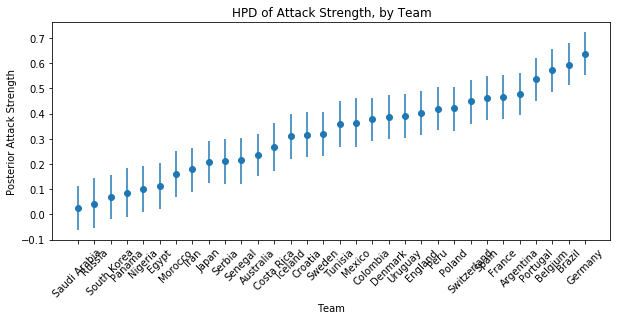

In [13]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['chance_creation'][:,wc_teams.i.values]), columns=['hpd_low', 'hpd_high'], index=wc_teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['chance_creation'][:,wc_teams.i.values])[50], columns=['hpd_median'], index=wc_teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

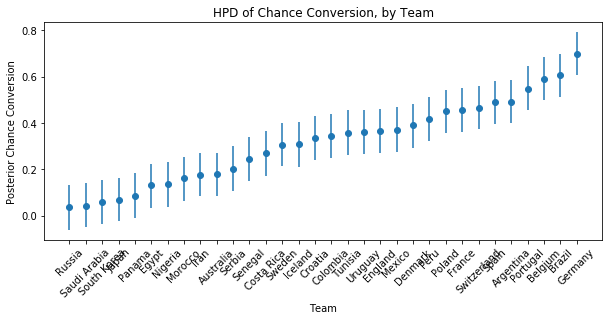

In [15]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['chance_quality'][:,wc_teams.i.values]), columns=['hpd_low', 'hpd_high'], index=wc_teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['chance_quality'][:,wc_teams.i.values])[50], columns=['hpd_median'], index=wc_teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Chance Conversion, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Chance Conversion')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

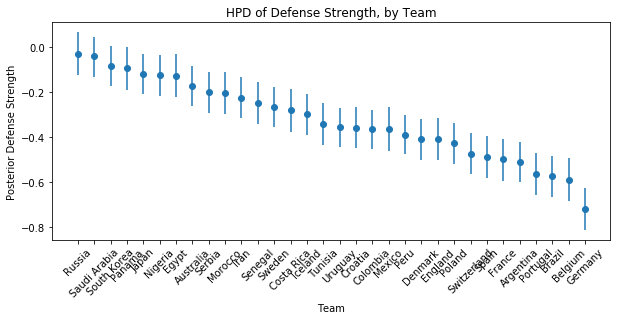

In [14]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['chance_supression'][:,wc_teams.i.values]), columns=['hpd_low', 'hpd_high'], index=wc_teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['chance_supression'][:,wc_teams.i.values])[50], columns=['hpd_median'], index=wc_teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median', ascending=False)
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Defense Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defense Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

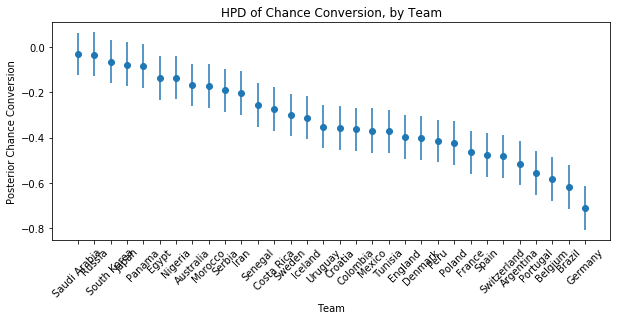

In [17]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['defense_quality'][:,wc_teams.i.values]), columns=['hpd_low', 'hpd_high'], index=wc_teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['defense_quality'][:,wc_teams.i.values])[50], columns=['hpd_median'], index=wc_teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median', ascending=False)
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Chance Conversion, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Chance Conversion')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

In [22]:
def simulate_match(trace, teams, home=(False,False)):
    num_samples = trace['chance_creation'].shape[0]
    idx = np.random.randint(0,num_samples)
    atts = trace['chance_creation'][idx, teams]
    defs = trace['chance_supression'][idx, teams]
    chance_quality = trace['chance_quality'][idx, teams]
    defense_quality = trace['defense_quality'][idx, teams]
    shots_inter = trace['shots_intercept'][idx]
    goals_inter = trace['goals_intercept'][idx]
    home_inter = trace['home'][idx]

    home_shots_theta = shots_inter + atts[0] + atts[1]
    if home[0]:
        home_shots_theta += home_inter
    away_shots_theta = shots_inter + atts[1] + atts[0]
    if home[1]:
        away_shots_theta += home_inter
    home_goals_theta = np.exp(goals_inter + home_shots_theta + chance_quality[0] + defense_quality[1])
    away_goals_theta = np.exp(goals_inter + away_shots_theta + chance_quality[1] + defense_quality[0])
    home_goals = np.random.poisson(home_goals_theta)
    away_goals = np.random.poisson(away_goals_theta)
    
    if home_goals > away_goals:
        return 'home'
    elif away_goals > home_goals:
        return 'away'
    else:
        return 'draw'
        
def simulate_group(group, trace, n_sims=100):
    indices = group.i.values
    pts = np.zeros(len(indices))
    for _ in range(n_sims):
        for i in range(len(indices)):
            for j in range(i+1,len(indices)):
                home_i = indices[i]
                away_i = indices[j]
                #if (group[group.i == home_i].team == 'Russia').values[0]:
                #    home = (True,False)
                #elif (group[group.i == away_i].team == 'Russia').values[0]:
                #    home = (False,True)
                #else:
                #    home = (False,False)
                home = (False,False)
                res = simulate_match(trace, [home_i,away_i], home)
                if res == 'home':
                    pts[i] += 3
                elif res == 'away':
                    pts[j] += 3
                else:
                    pts[i] += 1
                    pts[j] += 1
    pts /= n_sims
    res = pd.DataFrame(pts, index=indices, columns=['exp. points'])
    return group.join(res).sort_values(by='exp. points', ascending=False)

In [25]:
with mp.Pool(4) as pool:
    groups_res = pool.map(partial(simulate_group, trace=trace, n_sims=100), groups)

In [26]:
for res in groups_res:
    print(res)

             team    i  fifa_points  exp. points
126       Uruguay  126        976.0         5.85
179         Egypt  179        636.0         4.07
1          Russia    1        493.0         3.46
98   Saudi Arabia   98        462.0         3.15
         team    i  fifa_points  exp. points
75   Portugal   75       1306.0         6.28
34      Spain   34       1162.0         5.43
112      Iran  112        727.0         2.75
88    Morocco   88        681.0         2.58
          team    i  fifa_points  exp. points
83      France   83       1166.0         4.97
144    Denmark  144       1054.0         4.84
104       Peru  104       1106.0         4.48
52   Australia   52        700.0         2.53
          team    i  fifa_points  exp. points
65   Argentina   65       1254.0         6.13
58     Croatia   58        975.0         4.57
71     Iceland   71        930.0         3.55
163    Nigeria  163        635.0         2.68
            team    i  fifa_points  exp. points
64        Brazil   64 